In [1]:
# set to true to recompute BP positions from raw data

recompute = False

---

In [2]:
import micromagneticdata as mdata
from multiprocessing import Pool
import matplotlib.pyplot as plt
import numpy as np
import itertools
import json
import discretisedfield as df
import ast
import os

In [4]:
if recompute:
    data = mdata.Data(name='mbp_l_1000_w_100_ht_10_xixxx')
    data.info

In [5]:
if recompute:
    def bp_pos_x(filename):
        return ast.literal_eval(df.tools.count_bps(df.Field.from_file(filename))['bp_pattern_x'])[0][1]

    def bp_pos_y(filename):
        return ast.literal_eval(df.tools.count_bps(df.Field.from_file(filename), direction='y')['bp_pattern_y'])[0][1]
    
    res = {}
    with Pool(len(os.sched_getaffinity(0))) as p:
        for drive in range(2, 9):
            pos_x = p.map(bp_pos_x, data[drive]._step_files)
            pos_y = p.map(bp_pos_y, data[drive]._step_files)
            res[drive] = [data[drive].table.data['t'].to_list(), pos_x, pos_y]
else:
    with open("results-single.json", "rt") as f:
        res = json.load(f, object_pairs_hook=lambda pairs: {int(k): v for k, v in pairs})

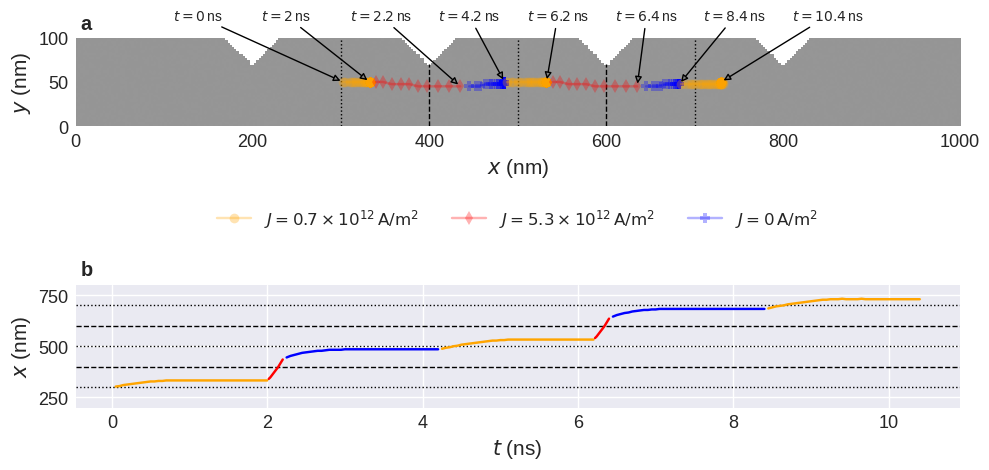

In [8]:
fig, axs = plt.subplots(figsize=(10, 5), nrows=3, gridspec_kw={'height_ratios': (3, .5, 2)}, layout='tight')
ax = axs[0]
ax.set_facecolor('white')
geometry = df.Field.from_file('geometry.omf')
geometry.valid = 'norm'
geometry.sel(z=1e-9).mpl.scalar(ax=ax, clim=(0, 2), cmap='Greys', colorbar=False, multiplier=1e-9)

for y in [400, 600]:
    notch = ax.axvline(y, c='black', linestyle='--', ymax=0.7, linewidth=1)
for y in [300, 500, 700]:
    wide = ax.axvline(y, c='black', linestyle=':', linewidth=1)

handles = []
for (_, xs, ys), c, m, label in zip(res.values(), itertools.cycle(['orange', 'red', 'blue']), itertools.cycle("odP"), itertools.cycle(['$J=0.5e12$', '$J=4e12$', '$J=0$'])):
    line, = ax.plot(np.array(xs) * 2.5, np.array(ys) * 2.5, linestyle='-', color=c, marker=m, label=label, alpha=0.3)
    handles.append(line)
ax.set_xlabel('$x$ (nm)')
ax.set_ylabel('$y$ (nm)')
ax.text(5, 110, 'a', fontweight='bold', fontsize='x-large')

ax.annotate('$t=0\,$ns', (res[2][1][0]*2.5, res[2][2][0]*2.5), (110, 120), arrowprops={'arrowstyle': '-|>', 'linewidth': 1, 'facecolor': 'grey'})
for i, text in [
    (2, '$t=2\,$ns'),
    (3, '$t=2.2\,$ns'),
    (4, '$t=4.2\,$ns'),
    (5, '$t=6.2\,$ns'),
    (6, '$t=6.4\,$ns'),
    (7, '$t=8.4\,$ns'),
    (8, '$t=10.4\,$ns'),
]:
    ax.annotate(text, (res[i][1][-1]*2.5, res[i][2][-1]*2.5), ((i - 2)*100 + 210, 120), arrowprops={'arrowstyle': '-|>', 'linewidth': 1, 'facecolor': 'grey'})
    
axs[1].legend(handles=handles[:3], frameon=False, loc='lower center', ncols=3, labels=[r'$J=0.7\times10^{12}\,\mathrm{A/m}^2$', r'$J=5.3\times10^{12}\,\mathrm{A/m}^2$', r'$J=0\,\mathrm{A/m}^2$'])
axs[1].set_axis_off()

ax = axs[2]
for y in [400, 600]:
    ax.axhline(y, c='black', linestyle='--', linewidth=1)
for y in [300, 500, 700]:
    ax.axhline(y, c='black', linestyle=':', linewidth=1)

t0 = 0
for i, c in zip(range(2, 9), itertools.cycle(['orange', 'red', 'blue'])):
    t_steps = res[i][0]
    ax.plot((t0 + np.array(t_steps))*1e9, np.array(res[i][1])*2.5, c=c)
    t0 += res[i][0][-1]
ax.set_ylim((200, 800))

ax.set_yticks([250, 500, 750])
ax.set_xlabel('$t$ (ns)')
ax.set_ylabel('$x$ (nm)')
ax.text(-.4, 850, 'b', fontweight='bold', fontsize='x-large')
ax.grid()

In [9]:
fig.savefig('Fig5.pdf')